<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

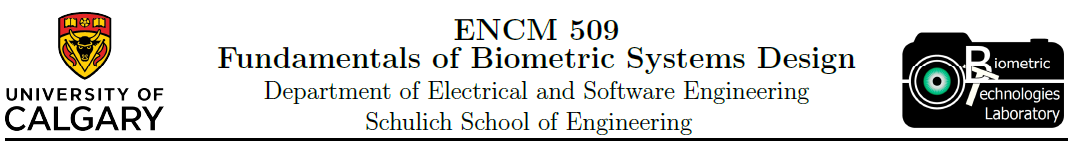

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

## Introduction:

In this week's lab we used the reader UareU 4500 to take ten good and bad images for both the left and right thumbs. We later use different types of image preprocessing and processing on the fingerprints and see how it effects the number of singularities and minutiaes. We also change the parameters block size and segmentation threshold and observed that effect as well. 

In [1]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

C:\Users\getab\AppData\Local\Temp\ipykernel_13316\1188667198.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


## Exercise 1:

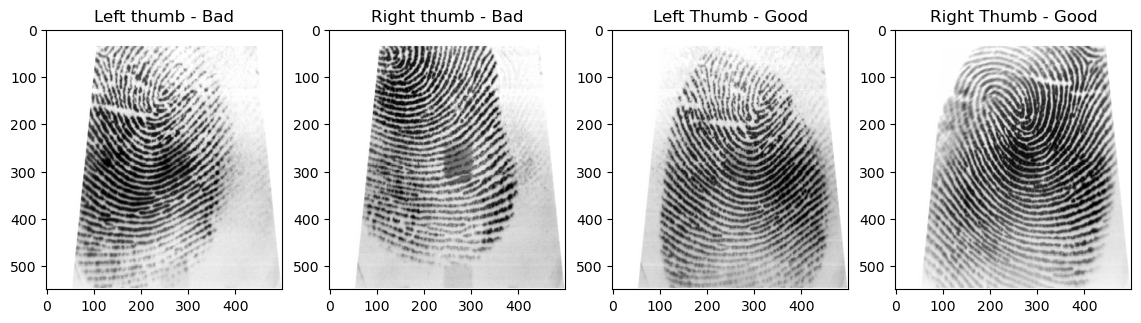

In [2]:
#displaying the four images

#bad = l4, r10
#good = l3, r9

images = {'l6':"Left thumb - Bad", 'r10':'Right thumb - Bad', 'l3':'Left Thumb - Good', 'r9':'Right Thumb - Good'}
original_images = {}
ind = 1
plt.figure(figsize=(14,6))
for k,v in images.items():
    img = img_as_ubyte(imread(f'fingerprints/{k}.bmp', as_gray=True))

    # copying the original image in case to use later on
    input_img = img.copy()
    original_images[v] = input_img
    
    plt.subplot(1, 4, ind)
    plt.title(v)
    ind+=1
    plt.imshow(img)
    

plt.show()

In [3]:
def fingerprint_processing(img , block_size =16, threshold =0.4,hist=False, histA=False, filtW=False, filtM=False):
    output = {}
    # normalization = removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize (img.copy(), float(100) , float(100))
    output['normalized img'] = normalized_img
    
    #depending on how the method was called, equalization or a filter will be applied before segmentation
    if hist:
        img_to_seg = img_as_ubyte(equalize_hist(normalized_img))
        output['hist'] = img_to_seg
    elif histA:
        img_to_seg = img_as_ubyte(equalize_adapthist(normalized_img))
        output['histA'] = img_to_seg
    elif filtW:
        img_wiener = wiener(normalized_img.astype('float'), (5,5))
        img_to_seg = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))
        output['filtW'] = img_to_seg
    elif filtM:
        img_to_seg = median(normalized_img)
        output['filtM'] = img_to_seg
    else:
        img_to_seg = normalized_img 
        
    # segmentation
    ( segmented_img , normim , mask) = segmentation(img_to_seg, 
                                                    block_size, 
                                                    threshold)
    output['segmented img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    # orientation estimation
    angles = calculate_angles(normalized_img,
                              W= block_size ,
                              smooth=True)
    output['angles'] = angles
    # find the overall frequency of ridges
    freq = ridge_freq (normim, mask , angles , block_size , kernel_size =5, minWaveLength =5, maxWaveLength =15)
    output['freq'] = freq
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim , angles , freq , block_size )
    output['gabor_img'] = gabor_img
    # create the skeleton
    thin_image = skeletonize( gabor_img )
    output['thin_image'] = thin_image
    # find the minutiae
    minutiae_lst , minutiae_img , minutiae_arr = calculate_minutiae ( thin_image , mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    # singularities
    singularities_lst , singularities_img = calculate_singularities( thin_image ,
    angles , block_size , mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    return output

Left thumb - Bad


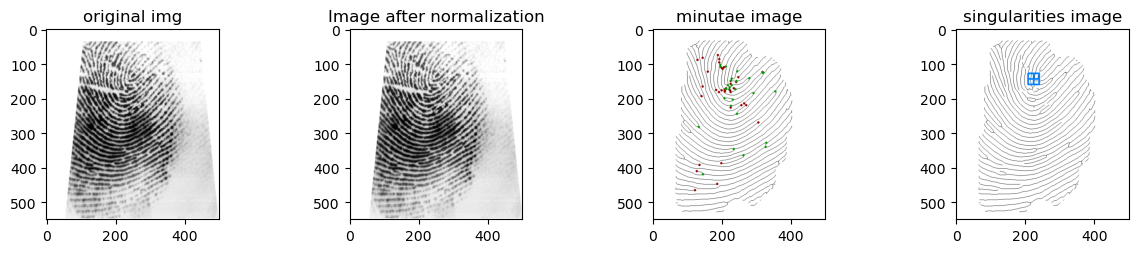

singularities: 4, minutiae: 64


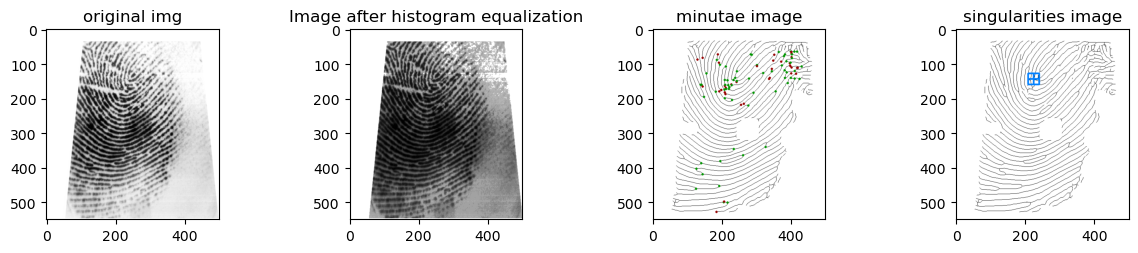

singularities: 4, minutiae: 97


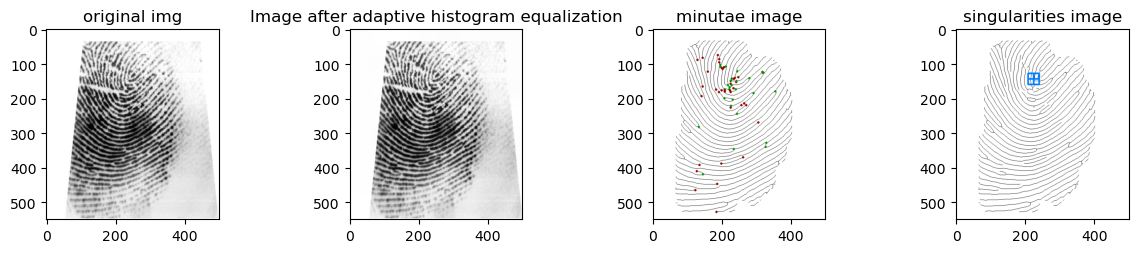

singularities: 4, minutiae: 65
-------------------------------------------------------------------------------------------------------------- 

Right thumb - Bad


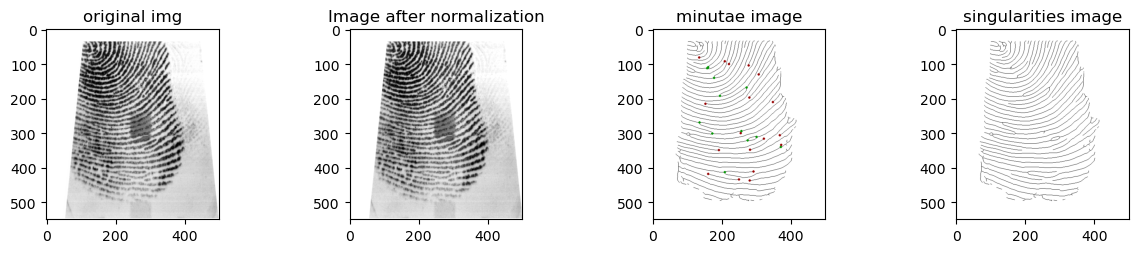

singularities: 0, minutiae: 31


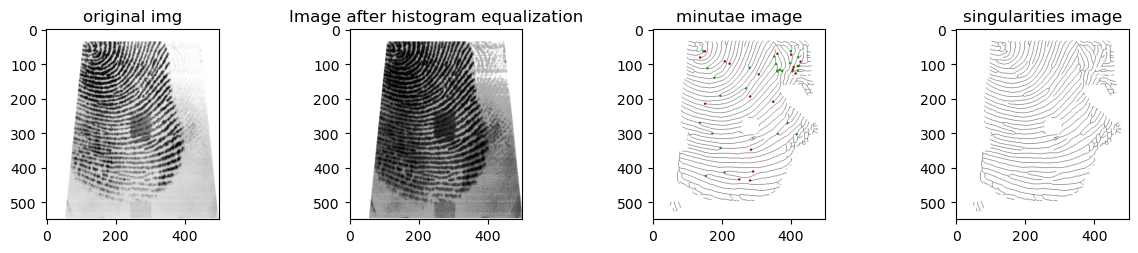

singularities: 0, minutiae: 45


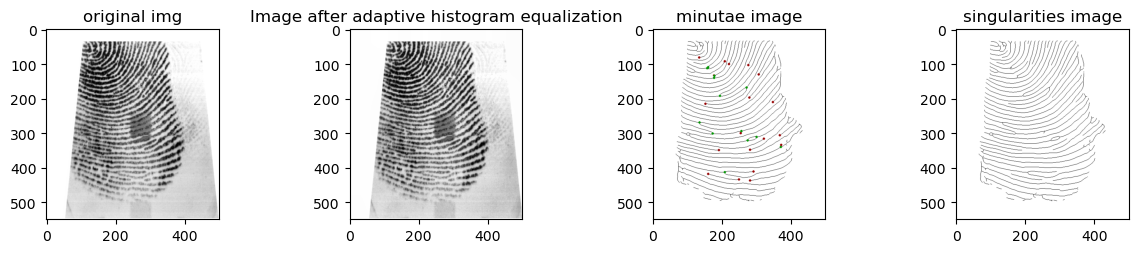

singularities: 0, minutiae: 33
-------------------------------------------------------------------------------------------------------------- 

Left Thumb - Good


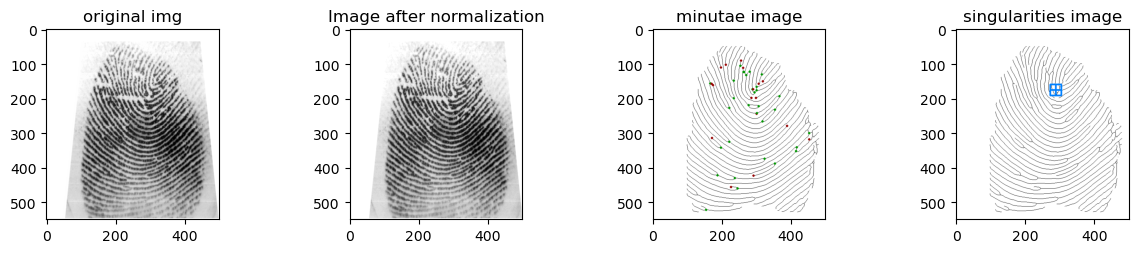

singularities: 4, minutiae: 48


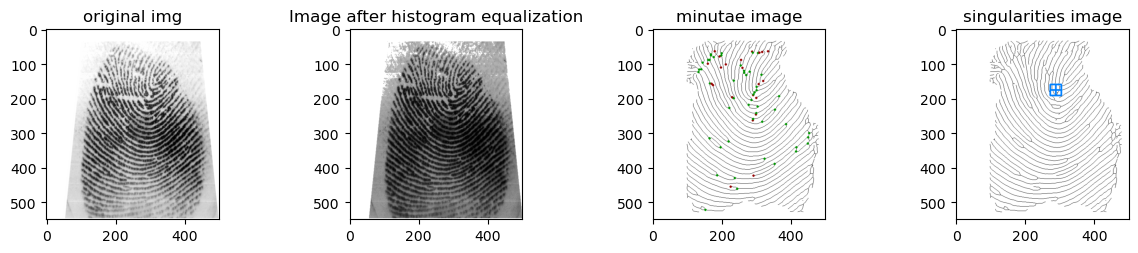

singularities: 4, minutiae: 73


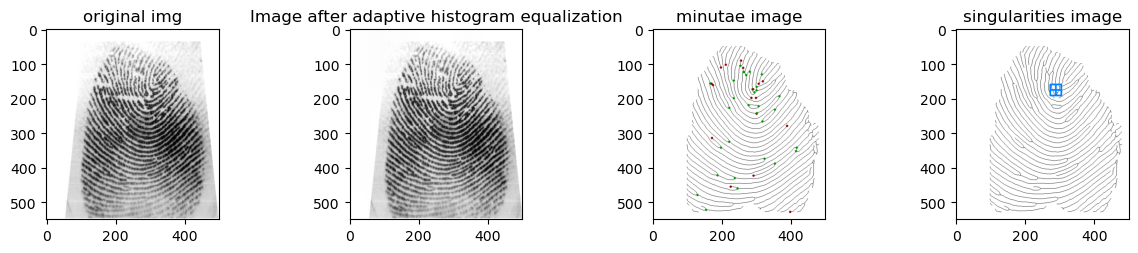

singularities: 4, minutiae: 48
-------------------------------------------------------------------------------------------------------------- 

Right Thumb - Good


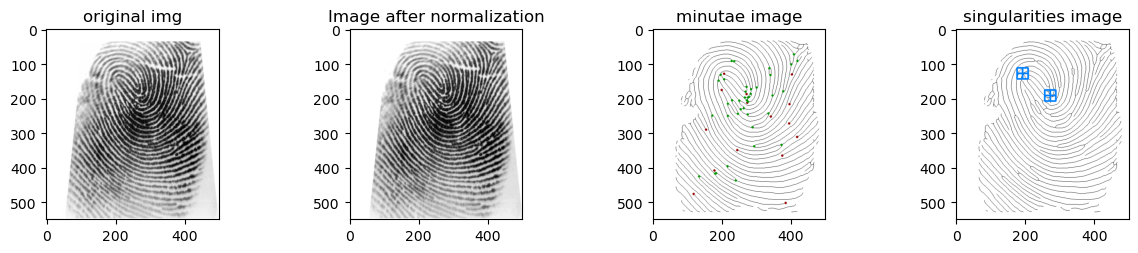

singularities: 8, minutiae: 55


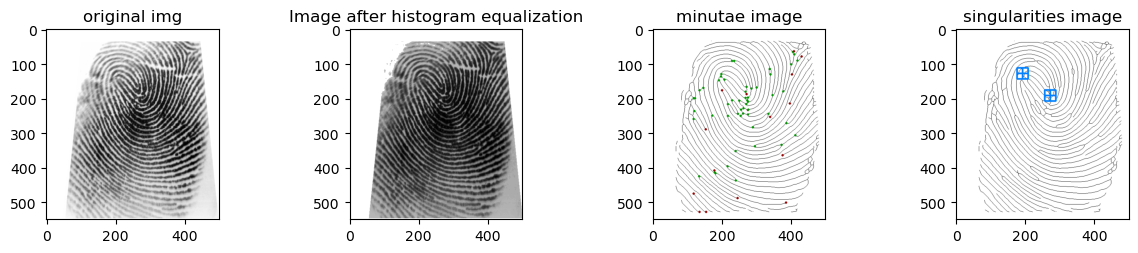

singularities: 8, minutiae: 69


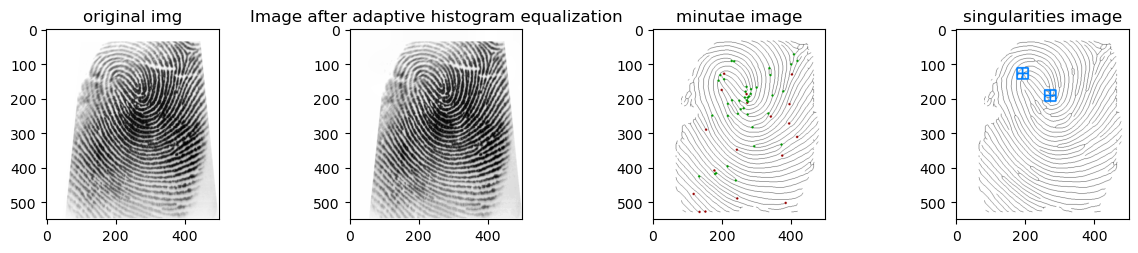

singularities: 8, minutiae: 58
-------------------------------------------------------------------------------------------------------------- 



In [4]:
# parameters for processing
seg_threshold = 0.2
block_size = 16

# parameters for the figure size
w=15
h=35

#applying preprocessing on all four images
#for each image preprocessing is done with and without equalization (regular and adaptive)
ind = 0
for k,v in original_images.items():
    img = v

    fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
    fp_h = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,hist=True )
    fp_a = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,histA=True )
    
    print(k) # name of the image (ex: left bad)

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+1)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+2)
    plt.imshow(fp['normalized img']); plt.title('Image after normalization')
    plt.subplot(12,4,ind+3)
    plt.imshow(fp['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+4)
    plt.imshow(fp['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp['singularities_lst'])}, minutiae: {len(fp['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+5)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+6)
    plt.imshow(fp_h['hist']); plt.title('Image after histogram equalization')
    plt.subplot(12,4,ind+7)
    plt.imshow(fp_h['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+8)
    plt.imshow(fp_h['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_h['singularities_lst'])}, minutiae: {len(fp_h['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+9)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+10)
    plt.imshow(fp_a['histA']); plt.title('Image after adaptive histogram equalization')
    plt.subplot(12,4,ind+11)
    plt.imshow(fp_a['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+12)
    plt.imshow(fp_a['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_a['singularities_lst'])}, minutiae: {len(fp_a['minutiae_lst'])}")
    
    ind = ind + 12
    print("-------------------------------------------------------------------------------------------------------------- \n")

For this exercise we observe the effect of applying histogram equalization or adaptive histogram equalization on the number of minutiae and singularities detected. 

For all four fingerprints, we observe that adaptive histogram equalization produced a more clear image with ridges more clearly defined. On the other hand, histogram equalization increased contrast in a manner where areas of the image that were not part of the fingerprint were included in the minutiae image, which increased the number of minutiae detected (false positives). This is most clearly displayed in the bad images of the left and right thumbs. Adaptive histogram equalization only slightly increased the number of minutiae detected, or kept it the same. 

For all four fingerprints, neither equalization technique made a difference in the number of singularities detected. Additionally, equalization did not allow for any singularity point to be detected in the bad right thumb, displaying the importance of the image quality itself.

## Exercise 2

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\scipy\signal\_signaltools.py:1625: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Left thumb - Bad


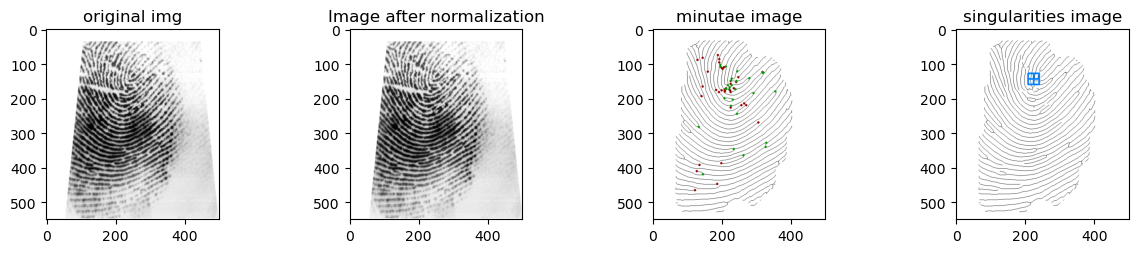

singularities: 4, minutiae: 64


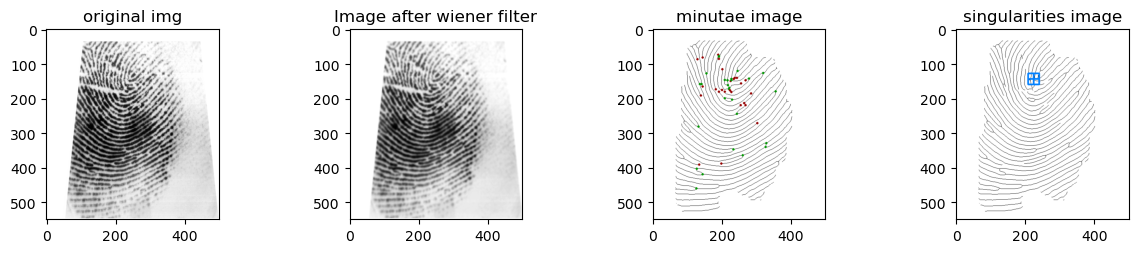

singularities: 4, minutiae: 53


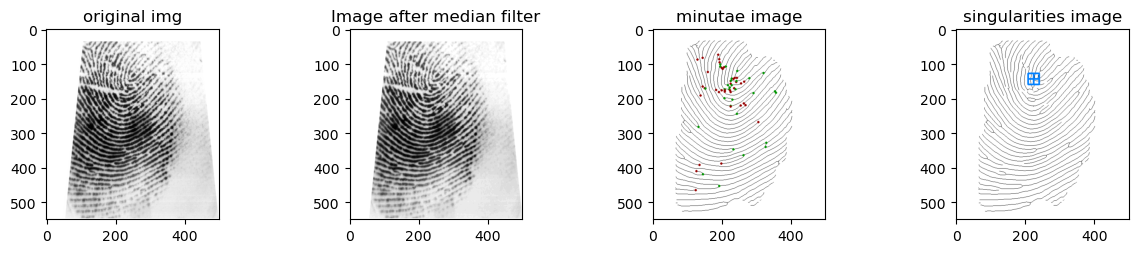

singularities: 4, minutiae: 67
-------------------------------------------------------------------------------------------------------------- 

Right thumb - Bad


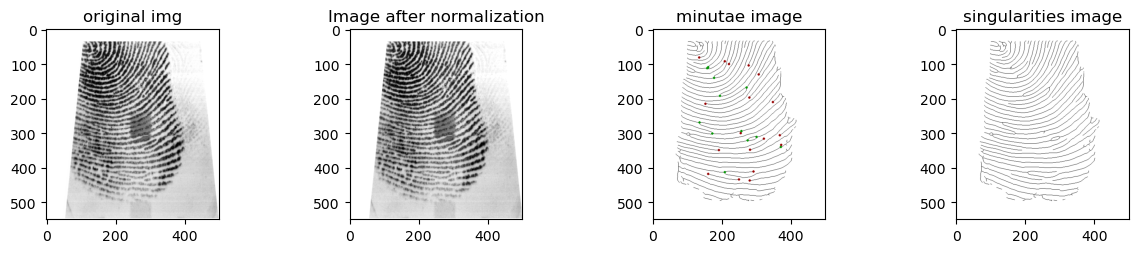

singularities: 0, minutiae: 31


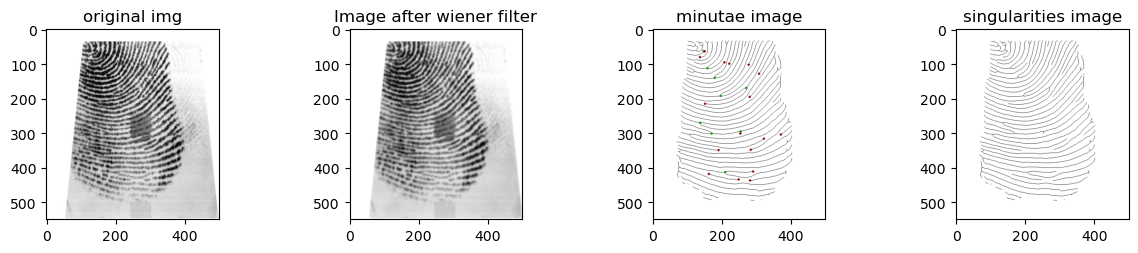

singularities: 0, minutiae: 26


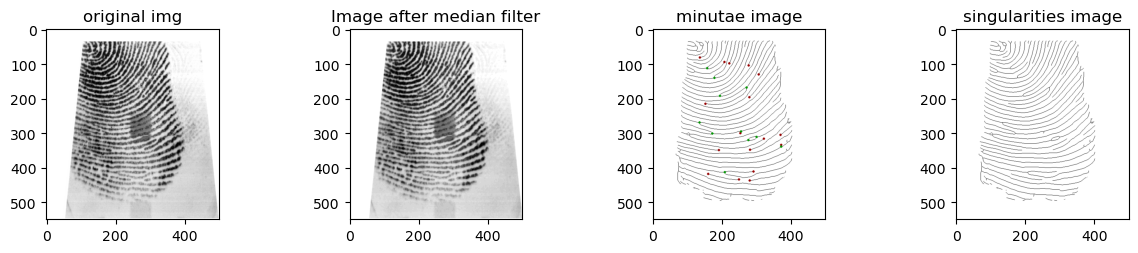

singularities: 0, minutiae: 28
-------------------------------------------------------------------------------------------------------------- 

Left Thumb - Good


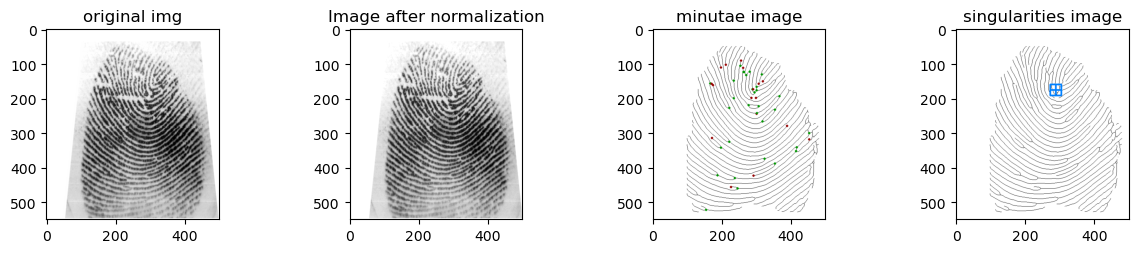

singularities: 4, minutiae: 48


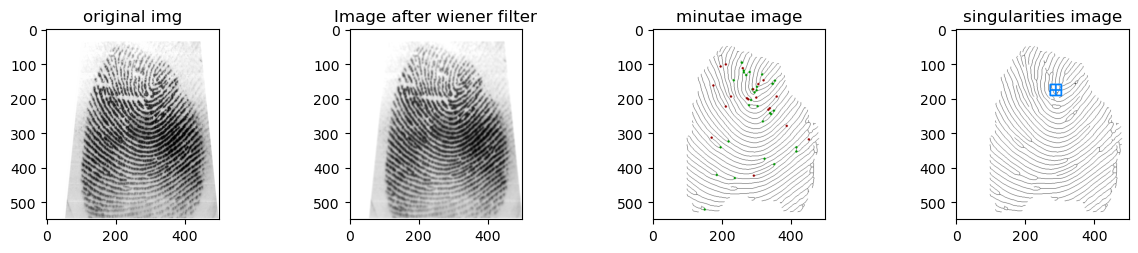

singularities: 4, minutiae: 50


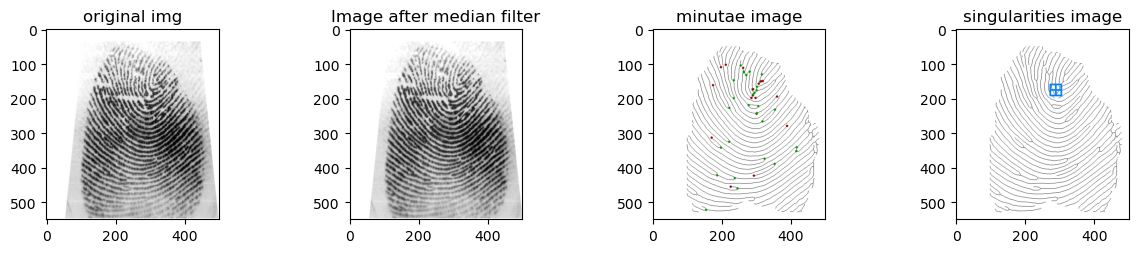

singularities: 4, minutiae: 47
-------------------------------------------------------------------------------------------------------------- 

Right Thumb - Good


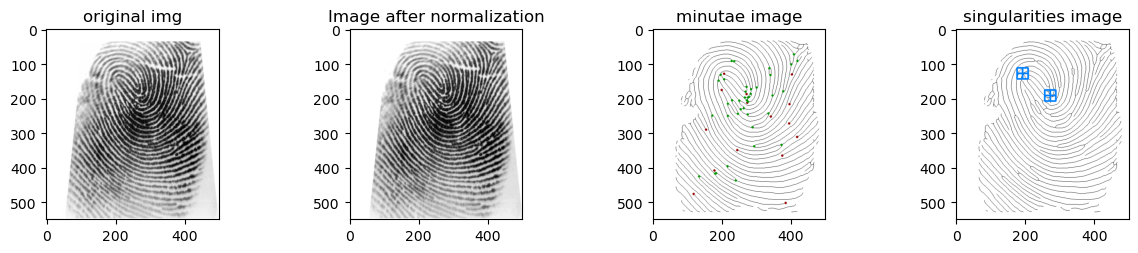

singularities: 8, minutiae: 55


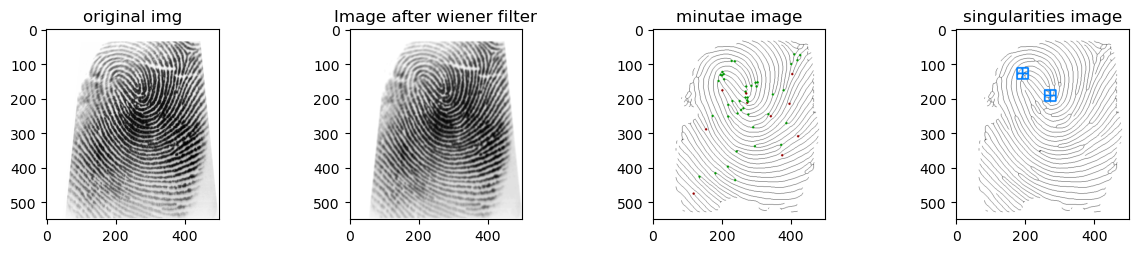

singularities: 8, minutiae: 53


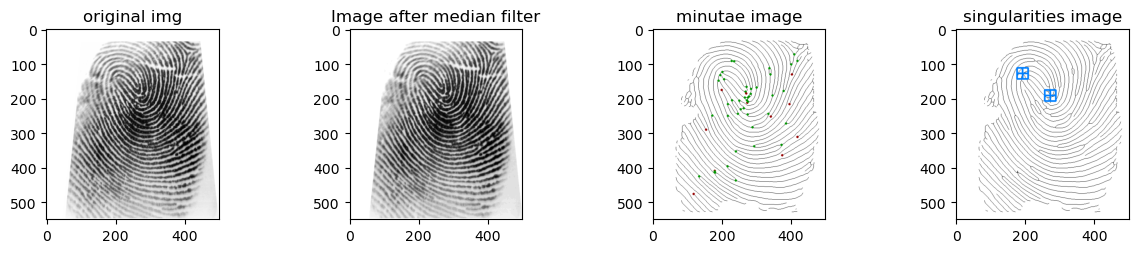

singularities: 8, minutiae: 56
-------------------------------------------------------------------------------------------------------------- 



In [5]:
import numpy
with numpy.errstate(divide='ignore'):
    numpy.float64(1.0) / 0.0
    
# parameters for processing
seg_threshold = 0.2
block_size = 16

# parameters for the figure size
w=15
h=35

#applying processing on all four images
#for each image processing is done with and without filters (wiener and median)
ind = 0
for k,v in original_images.items():
    img = v
    fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
    fp_w = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,filtW=True )
    fp_m = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,filtM=True )

    print(k)  # name of the image (ex: left bad)
    
    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+1)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+2)
    plt.imshow(fp['normalized img']); plt.title('Image after normalization')
    plt.subplot(12,4,ind+3)
    plt.imshow(fp['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+4)
    plt.imshow(fp['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp['singularities_lst'])}, minutiae: {len(fp['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+5)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+6)
    plt.imshow(fp_w['filtW']); plt.title('Image after wiener filter')
    plt.subplot(12,4,ind+7)
    plt.imshow(fp_w['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+8)
    plt.imshow(fp_w['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_w['singularities_lst'])}, minutiae: {len(fp_w['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+9)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+10)
    plt.imshow(fp_m['filtM']); plt.title('Image after median filter')
    plt.subplot(12,4,ind+11)
    plt.imshow(fp_m['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+12)
    plt.imshow(fp_m['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_m['singularities_lst'])}, minutiae: {len(fp_m['minutiae_lst'])}")
    
    ind = ind + 12
    print("-------------------------------------------------------------------------------------------------------------- \n")

For this exercise we observe how applying wiener or median filters affects the number of minutiae and singularities detected. 

For all four fingerprints, we observe that the median filter produced a more clear image while the wiener filter made the image slight blurry when compared to image after normalization with no filter at all. However the result of this on the number of minutiae varied. For the good left thumb image, minutiae increased while it decreased for the other three. 

The median filter also had varied results, the number of minutiae increased for the bad left thumb and good right thumb, and decreased for the other two, however this change was relatively small. And overall, neither filter had any effect on the number of singularities and did not produce any singularities for the bad right thumb image.

## Exercise 3

For this exercise we are changing the block size and segmentation threshold values to see how it impacts the number of singularities and minutiae from the fingerprint image processing. We have chosen the good left thumb image to experiment with the diferrent block size and segmentation threshold values. The 4 different pairs of block size and segmentation threshold used are (10,0.4),(10,0.5),(16,0.5),(16,0.4).

In [7]:
def plot_param_changes(block_size, seg_threshold, img, fp, fp_h, fp_a):
    w=15
    h=35
    
    print(f"blocksize:{block_size}, seg threshold: {seg_threshold}")
    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+1)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+2)
    plt.imshow(fp['normalized img']); plt.title('Image after normalization')
    plt.subplot(12,4,ind+3)
    plt.imshow(fp['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+4)
    plt.imshow(fp['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp['singularities_lst'])}, minutiae: {len(fp['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+5)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+6)
    plt.imshow(fp_h['hist']); plt.title('Image after histogram equalization')
    plt.subplot(12,4,ind+7)
    plt.imshow(fp_h['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+8)
    plt.imshow(fp_h['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_h['singularities_lst'])}, minutiae: {len(fp_h['minutiae_lst'])}")

    plt.figure(figsize=(w,h))
    plt.subplot(12,4,ind+9)
    plt.imshow(img); plt.title('original img')
    plt.subplot(12,4,ind+10)
    plt.imshow(fp_a['histA']); plt.title('Image after adaptive histogram equalization')
    plt.subplot(12,4,ind+11)
    plt.imshow(fp_a['minutiae_img']); plt.title('minutae image')
    plt.subplot(12,4,ind+12)
    plt.imshow(fp_a['singularities_img']); plt.title('singularities image')
    plt.show()
    print(f"singularities: {len(fp_a['singularities_lst'])}, minutiae: {len(fp_a['minutiae_lst'])}")
    print("------------------------------------------------------------------------------------------ \n")

Left Thumb - Good
blocksize:10, seg threshold: 0.4


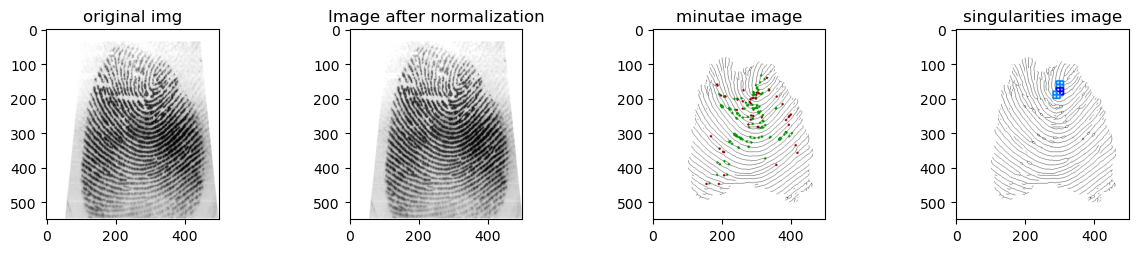

singularities: 10, minutiae: 178


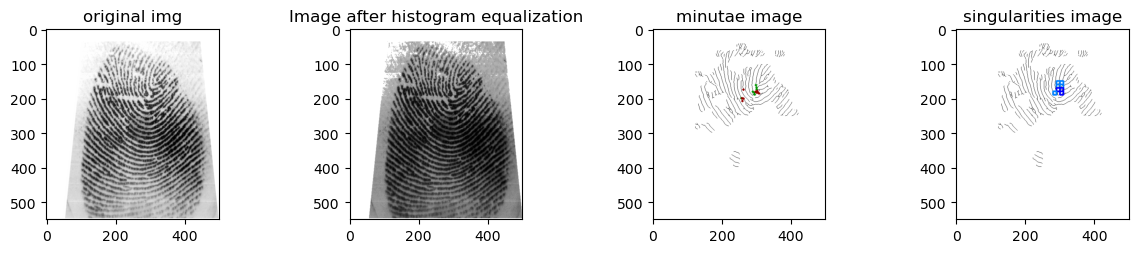

singularities: 8, minutiae: 16


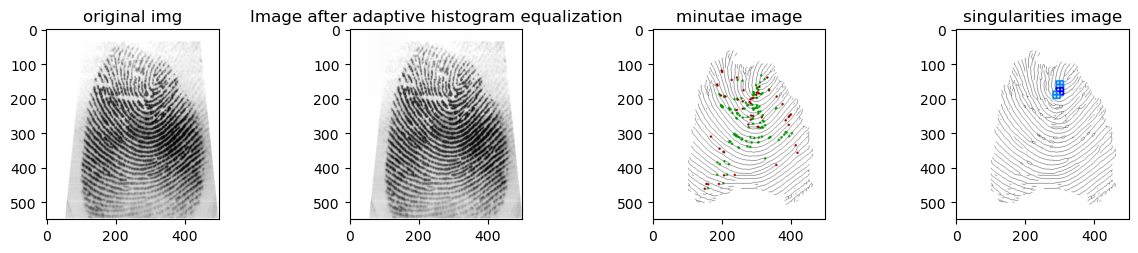

singularities: 10, minutiae: 189
------------------------------------------------------------------------------------------ 

blocksize:10, seg threshold: 0.5


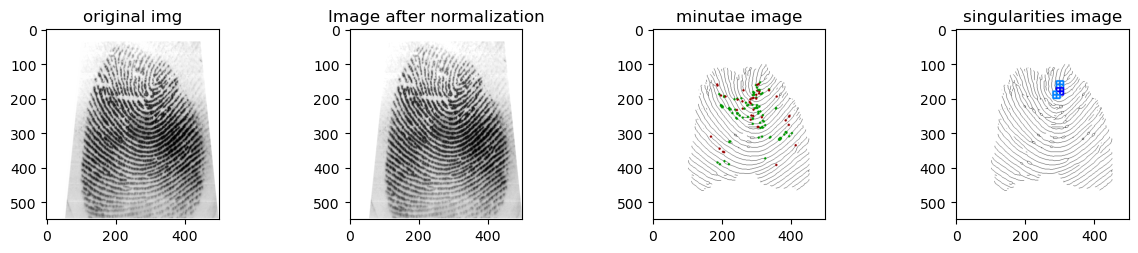

singularities: 10, minutiae: 137


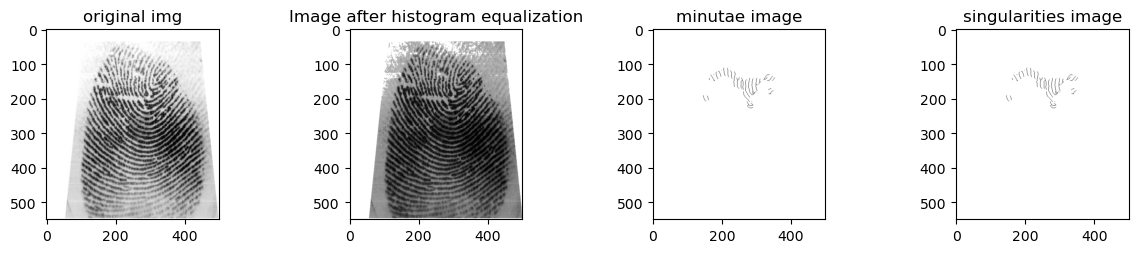

singularities: 0, minutiae: 0


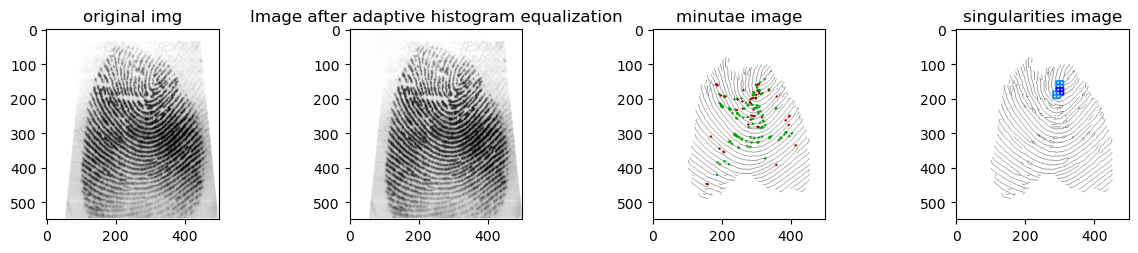

singularities: 10, minutiae: 175
------------------------------------------------------------------------------------------ 

blocksize:16, seg threshold: 0.4


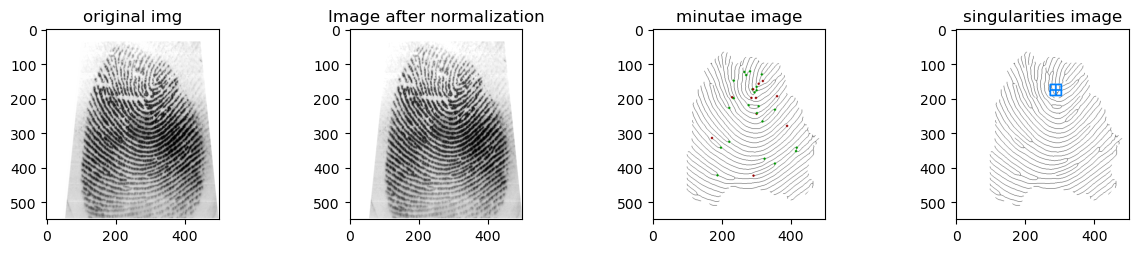

singularities: 4, minutiae: 35


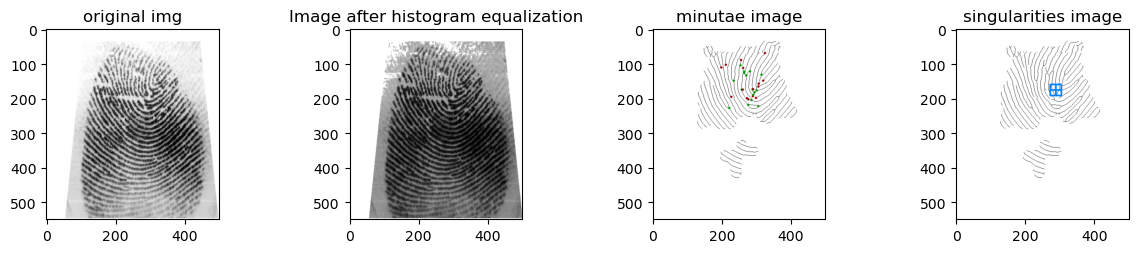

singularities: 4, minutiae: 31


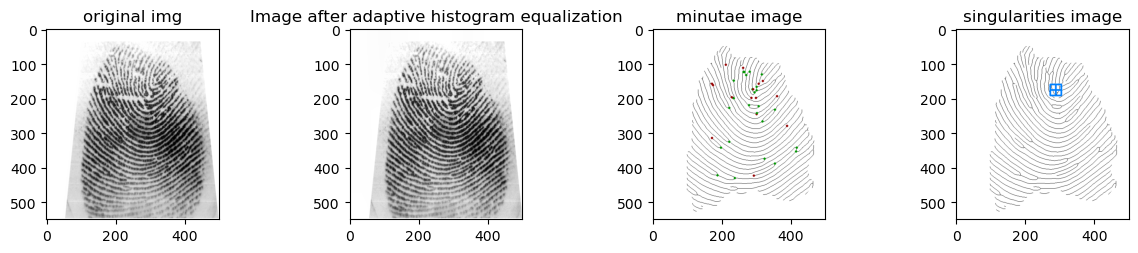

singularities: 4, minutiae: 41
------------------------------------------------------------------------------------------ 

blocksize:16, seg threshold: 0.5


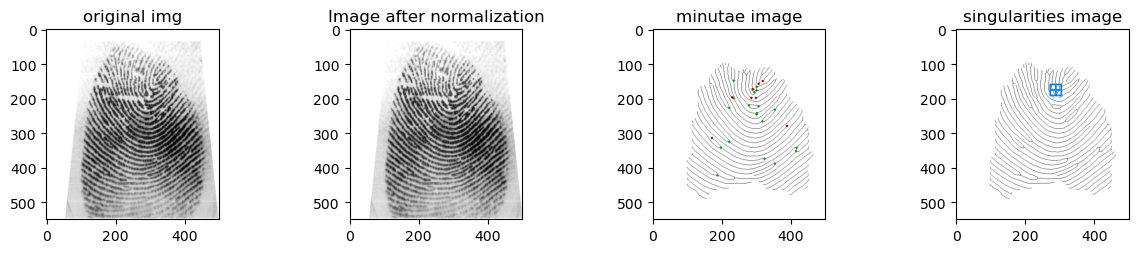

singularities: 4, minutiae: 29


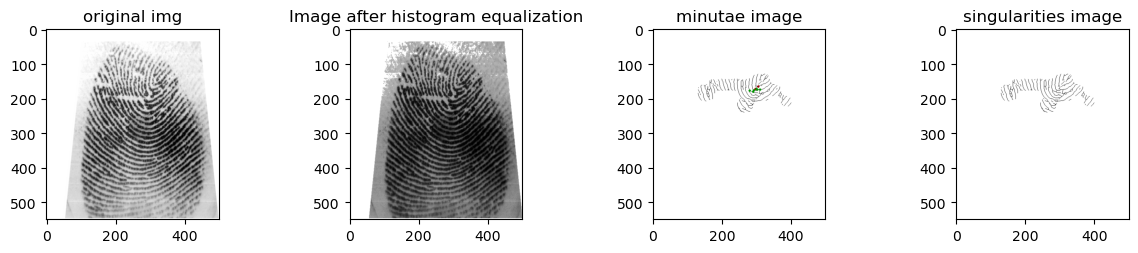

singularities: 0, minutiae: 8


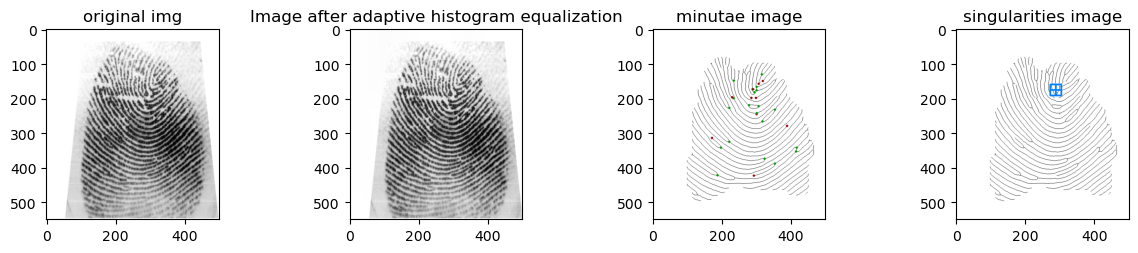

singularities: 4, minutiae: 31
------------------------------------------------------------------------------------------ 



In [8]:
#Effect of changing parameters seg_threshold and block_size
#Observing the effect with histogram equalization, ONLY on the image of the Left thumb (good)

img = original_images['Left Thumb - Good']
print('Left Thumb - Good') # name of the image (ex: left bad)
ind = 0
# parameters for processing
seg_threshold = 0.4
block_size = 10

#applying preprocessing
fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
fp_h = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,hist=True )
fp_a = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,histA=True )

plot_param_changes(block_size, seg_threshold, img, fp, fp_h, fp_a)



# parameters for processing
seg_threshold = 0.5
block_size = 10
#applying preprocessing
fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
fp_h = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,hist=True )
fp_a = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,histA=True )

plot_param_changes(block_size, seg_threshold, img, fp, fp_h, fp_a)


# parameters for processing
seg_threshold = 0.4
block_size = 16
#applying preprocessing
fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
fp_h = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,hist=True )
fp_a = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,histA=True )

plot_param_changes(block_size, seg_threshold, img, fp, fp_h, fp_a)



# parameters for processing
seg_threshold = 0.5
block_size = 16
#applying preprocessing
fp = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold)
fp_h = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,hist=True )
fp_a = fingerprint_processing (img , block_size = block_size , threshold = seg_threshold,histA=True )

plot_param_changes(block_size, seg_threshold, img, fp, fp_h, fp_a)

Some trends that we can see from the above results are as follows:
* Increasing the block size decreases the number of singularities and minutaes detected for all types of processing we tried.
* Keeping the block size constant, if we increase the segmentation threshold we can see that number of minutiae decreases.

We can also deduce that we saw the most number of singularities and minutiaes when we set our Block size and segmentation threshold values to 10 and 0.4 respectively. 

## Conclusion:

In this lab we obtained fingerprints and further analyzed 2 prints of poor quality and 2 of good quality. We also became familiar with the effect of histogram equalization, image filters, and the parameters block size and segmentation threshold. 

We found that adaptive histogram equalization creates a more defined image while just histogram equalization introduces false minutiae points. Furthermore, while the median filter produced a more clear image, the effect on the number of minutiae varied by image. Overall, neither technique had any affect on the number of singularities, and neither were able to improve the quality of the bad right thumb image enough for a single singularity point to be detected. 

Furthermore, when adjusting block size and segmentation threshold, increasing block size does in fact increase singularities (4 to 10 for the good left thumb image) and also number of minutiae, and increasing segmentation threshold decreases the number of minutiae. 

Overall, we observed the importance of image quality, using the correct preprocessing technique, and selecting the right parameters.

In [ ]:
for img in original_images:
    #applying preprocessing
    img_eq1 = img_as_ubyte(equalize_hist(img))
    img_eq2 = img_as_ubyte(equalize_adapthist(img))
    
    
    plt.figure(figsize=(14,6))
    plt.subplot(2,3,1)
    plt.imshow(img); plt.title('Original image')
    plt.subplot(2,3,2)
    plt.imshow(img_eq1); plt.title('Regular equalization')
    plt.subplot(2,3,3)
    plt.imshow(img_eq2); plt.title('Adaptive Equalization');
    plt.subplot(2,3,4)
    plt.hist(img.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,5)
    plt.hist(img_eq1.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,6)
    plt.hist(img_eq2.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity');

In [ ]:
# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# copying the original image in case to use later on
input_img = img.copy()

print(np.min(img), np.max(img))

plt.imshow(img);



### Preprocessing

#### Histogram Equalization

In [ ]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq1 = img_as_ubyte(equalize_hist(img))
img_eq2 = img_as_ubyte(equalize_adapthist(img))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq1); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq2); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

#### De-noising

In [ ]:
# two different denoising filters are applyed.
# you should chose one

# Wiener filter needs the input image as float (not uint8)
# the (5,5) corresponds to the sized of the window to considered during the processing.
img_wiener = wiener(img.astype('float'), (5,5))
# is necessary to convert the output back to uint8. 
# some additional steps are necessary to have it in 0-255. 
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))

# with the Median filter is not necessary to convert back to uint8 
img_median = median(img)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(img_wiener); plt.title('Wiener filter')
plt.subplot(1,3,3)
plt.imshow(img_median); plt.title('Median filter');

#### Parameters used for the next steps

In [ ]:
# block size usend for windowed processing
block_size = 16

# for segmentation
threshold = 0.2

 ### Normalization

In [ ]:
# normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(input_img.copy(), float(100), float(100))

plt.imshow(normalized_img);

### Segmentation

In [ ]:
(segmented_img, normim, mask) = segmentation(normalized_img, block_size, threshold)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(normim); plt.title('Image normalized')
plt.subplot(1,3,2)
plt.imshow(mask); plt.title('Mask of the fingerprint region')
plt.subplot(1,3,3)
plt.imshow(segmented_img); plt.title('Fingerprint segmented');

In [ ]:
contours = find_contours(mask, 0.8)

plt.imshow(img)
for c in contours:
    plt.plot(c[:, 1], c[:, 0], linewidth=2, c='red')
plt.title('Fingerprint contour')

### Orientation Estimation

In [ ]:
angles = calculate_angles(normalized_img, W=block_size, smooth=True)
orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(angles, cmap='viridis')
plt.title('Ridges angles')
plt.subplot(1,2,2)
plt.imshow(orientation_img)
plt.title('Ridges orientation');

### Ridges Frequency

In [ ]:
# find the overall frequency of ridges
freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

### Gabor Filtering

In [ ]:
# create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq, block_size2=block_size, kx=0.65, ky=0.65)

plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');

### Thinning or Skeletonize

In [ ]:
thin_image = skeletonize(gabor_img)

plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');
plt.subplot(1,2,2)
plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

### Minutiae

In [ ]:
# minutiae_lst is a list with all minutiae coordinates and its type: 
# bifurcation or ending.
# minutiae_img is an image of the minutiae already plot on top of the skeleton
minutiae_lst, minutiae_img, _ = calculate_minutiae(thin_image, mask)

plt.imshow(thin_image)

for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')

plt.title('Minutiae\nEndings: red - Bifurcations: green');
print('Total of minutiae detected: %d' % (len(minutiae_lst)))

In [ ]:
# singularities: whorl, loop and delta.
singularities_lst, singularities_img = calculate_singularities(thin_image, angles, block_size, mask)

plt.imshow(singularities_img)
plt.title('Singularities');
print('Total of singularities detected: %d' % (len(singularities_lst)))

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(thin_image)
for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')
plt.title('Minutiae\nEndings: red - Bifurcations: green');
plt.subplot(1,2,2)
plt.imshow(singularities_img)
plt.title('Singularities');

In [ ]:
plt.imshow(thin_image)

for p in singularities_lst:
    x,y = p[0], p[1]
    
    # color is defined according to the singularity
    if (p[2] == 'loop'):
        color = 'blue'
    elif (p[2] == 'delta'):
        color = (0, 0.5, 1)
    elif (p[2] == 'whorl'):
        color = (1, 0.6, 1)
        
    plt.plot(x,y, c=color, marker='.')

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_img, cmap='gray');
plt.subplot(2,4,2); plt.imshow(normalized_img, cmap='gray')
plt.subplot(2,4,3); plt.imshow(segmented_img, cmap='gray');
plt.subplot(2,4,4); plt.imshow(orientation_img);
plt.subplot(2,4,5); plt.imshow(gabor_img, cmap='gray');
plt.subplot(2,4,6); plt.imshow(thin_image, cmap='gray');
plt.subplot(2,4,7); plt.imshow(minutiae_img);
plt.subplot(2,4,8); plt.imshow(singularities_img);

### All the steps above compiled in one function

In [ ]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Matching

##### Loading and processing

In [ ]:
# loading two images for Minutiae extraction and matching
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/2.bmp', as_gray=True))

# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(im1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(im2, block_size=block_size, threshold=seg_threshold)

##### Score based on Minutiae

In [ ]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

#### Score based on Gabor features

In [ ]:
score2 = MatchGaborFeat(im1, im2)
print('Score using Gabor features: %.4f' % (score2))

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART I: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

**PART II: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file `Lab04Fingerprint2gab.ipynb` to perform the Gabor filtering on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.